# Creating the main data file for this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table

import kepler_kinematics as kek
from tools import getDust
from photometric_teff import bprp_to_teff
from dustmaps.bayestar import BayestarQuery

# Set defaults so they don't change
import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set('v4.0')

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


# Load Gaia data

In [2]:
with fits.open("../../data/kepler_edr3_1arcsec.fits") as data:
    gaia_nodist = pd.DataFrame(data[1].data, dtype="float64")

Plot the angular separations between gaia-kepler crossmatch and dr2-edr3 crossmatch.

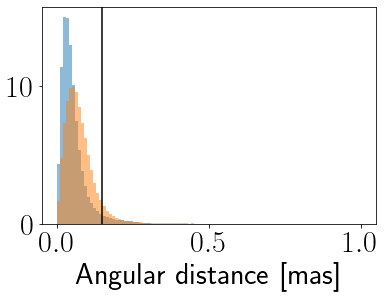

In [3]:
plt.hist(gaia_nodist.angdist*1e3, 100, range=(0, 1), density=True, alpha=.5);
plt.hist(gaia_nodist.kepler_gaia_ang_dist, 100, range=(0, 1), density=True, alpha=.5);
plt.axvline(.15, color="k")
plt.xlabel("Angular distance [mas]");

Loading (hopefully) Bailer-Jones distances. 

In [4]:
with fits.open("../data/distances-result.fits") as data:
    dist = pd.DataFrame(data[1].data, dtype="float64")

In [5]:
np.array([k for k in dist.keys()])

array(['source_id', 'ra', 'dec', 'r_med_geo', 'r_lo_geo', 'r_hi_geo',
       'r_med_photogeo', 'r_lo_photogeo', 'r_hi_photogeo', 'bp_rp',
       'qg_geo', 'gq_photogeo'], dtype='<U14')

Remove stars with negative parallaxes, apply S/N cuts, and remove stars with large angular separations.

In [6]:
gaia0 = pd.merge(gaia_nodist, dist, how="left", on="source_id", suffixes=["", "_bailer-jones"])
print(len(gaia0), "original stars")

# Remove stars with negative parallaxes and apply some S/N cuts.
m = (gaia0.parallax.values > 0) & np.isfinite(gaia0.parallax.values)

sn = gaia0.parallax.values/gaia0.parallax_error.values
m = (sn > 10)

m &= gaia0.astrometric_excess_noise.values < 5

# Joel's recommendations
m &= gaia0.ruwe.values < 1.4
m &= gaia0.ipd_frac_multi_peak.values <= 2 
m &= gaia0.ipd_gof_harmonic_amplitude.values < 0.1

gaia0 = gaia0.iloc[m]
print(len(gaia0), "stars after S/N and binary cuts")

# Remove stars with large angular separations between crossmatches.
m = gaia0.angdist.values*1e3 < .15
m &= gaia0.kepler_gaia_ang_dist.values < .15

gaia0 = gaia0.iloc[m]
print(len(gaia0), "stars after angular distance cuts")

214626 original stars
179086 stars after S/N and binary cuts
163026 stars after angular distance cuts


Drop targets with multiple matches.

In [7]:
def drop_multi_matches(df, ang_sep_column, duplicated_column):
    df_sorted = df.sort_values(by=ang_sep_column, ascending=True)
    df_dropped = df_sorted.drop_duplicates(subset=duplicated_column, keep="first")
    return df_dropped

In [8]:
# If a target is duplicated, keep the one with the smallest angular separation.
# Drop stars with the same Kepler ID
gaia_dropped = drop_multi_matches(gaia0, "kepler_gaia_ang_dist", "kepid")
print(len(gaia0)-len(gaia_dropped), "Stars with the same Kepler ID dropped")

# Drop stars with the same Gaia ID
gaia = drop_multi_matches(gaia_dropped, "kepler_gaia_ang_dist", "source_id")
print(len(gaia_dropped)-len(gaia), "Stars with the same Gaia ID dropped")

print("shape after cuts = ", np.shape(gaia))

12272 Stars with the same Kepler ID dropped
476 Stars with the same Gaia ID dropped
shape after cuts =  (150278, 144)


Load the LAMOST-Gaia-Kepler crossmatch perfomed in Lamost_xmatching.ipynb and remove stars with separations larger than .15 arcseconds.

In [9]:
lamost0 = pd.read_csv("../data/lamost_gaia_kepler_crossmatch.csv")
lam_cut = lamost0.gaia_lamost_angular_separation_arcsec.values < .15
lamost = lamost0.iloc[lam_cut]

print(f"{len(lamost0)-len(lamost)} of {len(lamost0)} stars with large angular separations removed")

8465 of 62217 stars with large angular separations removed


In [10]:
# np.array([k for k in lamost.keys()])

Plot Gaia vs. LAMOST temperatures (cuts applied in Lamost_xmatching.ipynb) and angular separation cuts.

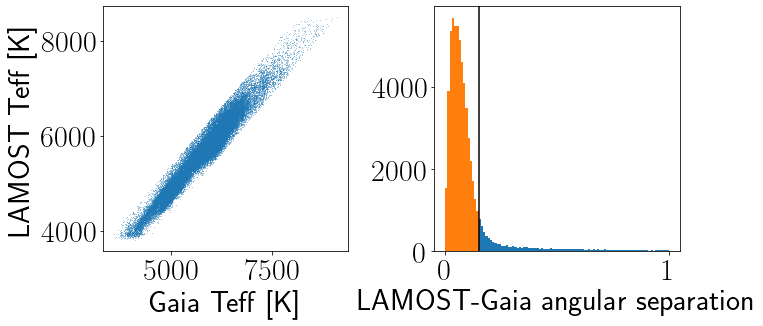

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lamost.teff.values, lamost.teff_lamost.values, ".", ms=2, alpha=.5, mec="none", rasterized=True)
plt.xlabel("Gaia Teff [K]")
plt.ylabel("LAMOST Teff [K]")

plt.subplot(1, 2, 2)
plt.hist(lamost0.gaia_lamost_angular_separation_arcsec, 100, range=(0, 1));
plt.hist(lamost.gaia_lamost_angular_separation_arcsec, 100, range=(0, 1));
plt.axvline(.15, color="k")
plt.xlabel("LAMOST-Gaia angular separation")

plt.tight_layout()

Just keep the lamost columns you need.

In [12]:
lam = pd.DataFrame(dict({"source_id": lamost.source_id.values,
                          "LAMOST_RV": lamost.rv.values,
                          "LAMOST_RV_ERR": lamost.rv_err.values,
                          "LAMOST_DESIGNATION": lamost.designation_lamost.values,
                          "LAMOST_TEFF": lamost.teff_lamost.values,
                          "LAMOST_TEFF_ERR": lamost.teff_err.values,
                          "gaia_lamost_angular_separation_arcsec": lamost.gaia_lamost_angular_separation_arcsec.values}))

Drop sources with multiple matches.

In [13]:
lamost_dropped = drop_multi_matches(lam, "gaia_lamost_angular_separation_arcsec", "source_id")
print(len(lam)-len(lamost_dropped), "Stars with the same Gaia source ID dropped")
lamost_dropped2 = drop_multi_matches(lamost_dropped, "gaia_lamost_angular_separation_arcsec", "LAMOST_DESIGNATION")
print(len(lamost_dropped)-len(lamost_dropped2), "Stars with the same LAMOST ID dropped")

54 Stars with the same Gaia source ID dropped
0 Stars with the same LAMOST ID dropped


# Load APOGEE data

In [14]:
# Load Joel's APOGEE-Gaia EDR3 Xmatch
tbl = Table.read("../data/apogee_dr16_tmass_psc_edr3_xmatch.fits", format='fits')  # This is Joel's new version
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
_apo3 = tbl[names].to_pandas()

In [15]:
# np.array([k for k in _apo3.keys()])

Just keep columns you need.

In [16]:
apo3 = pd.DataFrame(dict({"dr2_source_id": _apo3.dr2_source_id.values,
                          "dr3_source_id": _apo3.dr3_source_id.values,
                          "tmass_edr3_angular_distance": _apo3.tmass_edr3_angular_distance.values}))

In [17]:
# Load Adrian's APOGEE-Gaia DR2 crossmatch
tbl = Table.read("../data/apogeedr16_stars.fits", format='fits')
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
_apo2 = tbl[names].to_pandas()

In [18]:
# np.array([k for k in _apo2.keys()]) # See https://www.sdss.org/dr12/irspec/radialvelocities/
[col for col in _apo2.columns if "VSCATTER" in col]

['VSCATTER', 'OBSVSCATTER', 'SYNTHVSCATTER']

Again, just the columns you need.

In [19]:
apo2 = pd.DataFrame(dict({"dr2_source_id": _apo2.GAIA_SOURCE_ID.values,
                          "APOGEE_RV": _apo2.VHELIO_AVG.values,
                          "APOGEE_RV_err": _apo2.VERR.values,
                          "APOGEE_TEFF": _apo2.TEFF.values,
                          "APOGEE_TEFF_ERR": _apo2.TEFF_ERR.values,
                          "VSCATTER": _apo2.VSCATTER.values,
                          "APOGEE_ID": _apo2.APOGEE_ID.values}))

In [20]:
# Merge on Gaia DR2 source ID. 
apo1 = pd.merge(apo2, apo3, how="left", on="dr2_source_id")

# Merge with the Gaia-Kepler crossmatch
apo0 = pd.merge(gaia, apo1, left_on="source_id", right_on="dr2_source_id")

In [21]:
# np.array([k for k in apo0.keys()])

Remove stars with very different effective temperatures and stars with large angular separations.

In [22]:
apo_residuals = apo0.APOGEE_TEFF.values - apo0.teff.values
median = np.median(apo_residuals)
m_apo = (apo_residuals < median + 500) & (median - 500 < apo_residuals)
apo_cut = apo0.tmass_edr3_angular_distance.values < .15
apo = apo0.iloc[apo_cut & m_apo]

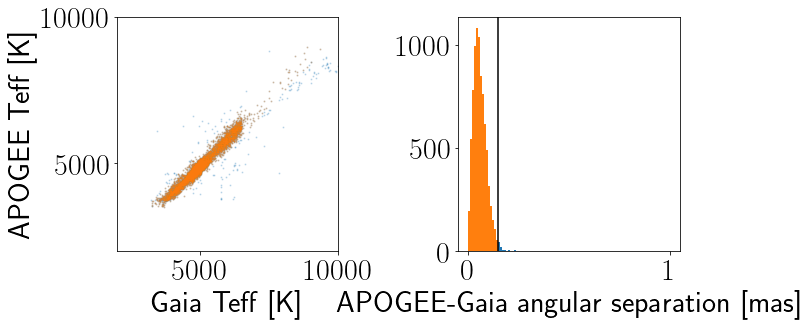

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(apo0.teff.values, apo0.APOGEE_TEFF.values, ".", ms=2, alpha=.2, rasterized=True)
plt.plot(apo.teff.values, apo.APOGEE_TEFF.values, ".", ms=2, alpha=.2, rasterized=True)
plt.xlim(2000, 10000)
plt.ylim(2000, 10000)
plt.xlabel("Gaia Teff [K]")
plt.ylabel("APOGEE Teff [K]")

plt.subplot(1, 2, 2)
plt.hist(apo0.tmass_edr3_angular_distance, 100, range=(0, 1));
plt.hist(apo0.tmass_edr3_angular_distance[apo_cut], 100, range=(0, 1));
plt.axvline(.15, color="k")
plt.xlabel("APOGEE-Gaia angular separation [mas]")

plt.tight_layout()

Drop stars with multiple matches.

In [24]:
apo_dropped = drop_multi_matches(apo, "tmass_edr3_angular_distance", "source_id")
print(len(apo)-len(apo_dropped), "Stars with the same Gaia source ID dropped")
apo_dropped2 = drop_multi_matches(apo_dropped, "tmass_edr3_angular_distance", "APOGEE_ID")
print(len(apo_dropped)-len(apo_dropped2), "Stars with the same APOGEE ID dropped")

46 Stars with the same Gaia source ID dropped
0 Stars with the same APOGEE ID dropped


Just keep the parameters you're interested in.

In [25]:
apo_stripped = pd.DataFrame(dict({"dr2_source_id": apo_dropped.dr2_source_id.values,
                                  "source_id": apo_dropped.source_id.values,
                                  "APOGEE_RV": apo_dropped.APOGEE_RV.values,
                                  "APOGEE_RV_ERR": apo_dropped.APOGEE_RV_err.values,
                                  "APOGEE_TEFF": apo_dropped.APOGEE_TEFF.values,
                                  "APOGEE_TEFF_ERR": apo_dropped.APOGEE_TEFF_ERR.values,
                                  "VSCATTER": apo_dropped.VSCATTER.values,
                                  "APOGEE_ID": apo_dropped.APOGEE_ID.values}))

Crossmatch back with the Gaia-Kepler crossmatch.

In [26]:
gaia_kep_lamost = pd.merge(gaia, lamost_dropped, on="source_id", how="left")
gaia_kep_lamost_apogee = pd.merge(gaia_kep_lamost, apo_stripped, on="source_id", how="left")

In [27]:
print(np.shape(gaia), np.shape(gaia_kep_lamost), np.shape(gaia_kep_lamost_apogee))

(150278, 144) (150278, 150) (150278, 157)


In [28]:
# Save file here.
gaia_kep_lamost_apogee.to_csv("../data/gaia_kep_lamost_apogee.csv")

In [29]:
df = gaia_kep_lamost_apogee*1

In [30]:
# np.array([k for k in df.keys()])

# Now correct the LAMOST and APOGEE RVs to Gaia.

In [31]:
rv, rv_err = [np.ones(len(df))*np.nan for i in range(2)]

ml = np.isfinite(df.LAMOST_RV.values)
mg = np.isfinite(df.dr2_radial_velocity.values) & (df.dr2_radial_velocity.values != 0)
ma = np.isfinite(df.APOGEE_RV.values)
mlmgma = ml & mg & ma
mlmg = ml & mg
mamg = ma & mg
maml = ma & ml

In [32]:
print(f"{len(df)} stars in total, {sum(ml)} with LAMOST RVs, {sum(ma)} with APOGEE RVs, {sum(mg)} with Gaia DR2 RVs, "\
      f"and {sum(mlmgma)} with all three")

150278 stars in total, 22420 with LAMOST RVs, 7697 with APOGEE RVs, 23013 with Gaia DR2 RVs, and 1981 with all three


Correct the LAMOST RVs to the Gaia ones:

In [33]:
def fit_line(x, y, yerr):
    AT = np.vstack((np.ones(len(x)), x))
    C = np.eye(len(x))*yerr
    CA = np.linalg.solve(C, AT.T)
    Cy = np.linalg.solve(C, y)
    ATCA = np.dot(AT, CA)
    ATCy = np.dot(AT, Cy)
    w = np.linalg.solve(ATCA, ATCy)

    cov = np.linalg.inv(ATCA)
    sig = np.sqrt(np.diag(cov))
    return w, sig

In [34]:
# Correct LAMOST RVs
x, y = df.dr2_radial_velocity.values[mlmg], df.LAMOST_RV.values[mlmg]-df.dr2_radial_velocity.values[mlmg]
yerr = df.LAMOST_RV_ERR.values[mlmg]
w, sig = fit_line(x, y, yerr)

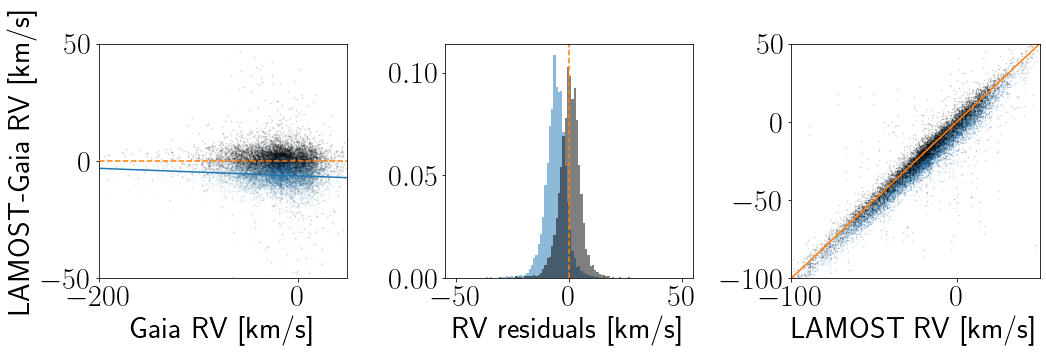

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

plt.errorbar(x, y, fmt="C0.", ms=1, alpha=.1, rasterized=True, zorder=1)

xs = np.linspace(min(x), max(x), 100)
plt.plot(xs, w[0] + w[1]*xs, zorder=2, color="C0")
plt.axhline(0, color="C1", ls="--", zorder=3)
plt.xlim(-200, 50)
plt.ylim(-50, 50)

plt.errorbar(x, y-(w[0]+w[1]*y), fmt="k.", ms=2, alpha=.1, rasterized=True, zorder=0)

plt.xlabel("Gaia RV [km/s]")
plt.ylabel("LAMOST-Gaia RV [km/s]")

lamost_corrected = df.LAMOST_RV.values - (w[0] + w[1]*df.LAMOST_RV.values)
df["lamost_corrected_rv"] = lamost_corrected

plt.subplot(1, 3, 2)
plt.hist(y, 100, density=True, alpha=.5, range=(-50,50));
plt.hist(y-(w[0]+w[1]*y), 100, density=True, alpha=.5, range=(-50,50), color="k");
plt.axvline(0, color="C1", ls="--")
plt.xlabel("RV residuals [km/s]")

plt.subplot(1, 3, 3)
plt.plot(df.dr2_radial_velocity.values[mlmg], df.LAMOST_RV.values[mlmg], ".", ms=1, alpha=.2, rasterized=True)
plt.plot(df.dr2_radial_velocity.values[mlmg], df.lamost_corrected_rv.values[mlmg], "k.", ms=1, alpha=.2, rasterized=True)
plt.plot(xs, xs)
plt.xlim(-100, 50)
plt.ylim(-100, 50)
plt.xlabel("Gaia RV [km/s]")
plt.xlabel("LAMOST RV [km/s]")

plt.tight_layout()

In [36]:
# Correct APOGEE RVs
x, y = df.dr2_radial_velocity.values[mamg], df.APOGEE_RV.values[mamg]-df.dr2_radial_velocity.values[mamg]
yerr = df.APOGEE_RV_ERR.values[mamg]
w, sig = fit_line(x, y, yerr)

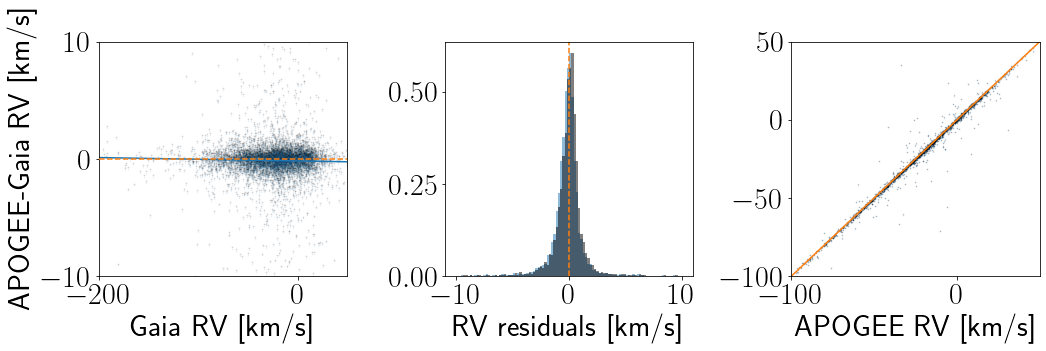

In [37]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

plt.errorbar(x, y, fmt="C0.", ms=1, alpha=.1, rasterized=True, zorder=1)

xs = np.linspace(min(x), max(x), 100)
plt.plot(xs, w[0] + w[1]*xs, zorder=2, color="C0")
plt.axhline(0, color="C1", ls="--", zorder=3)
plt.xlim(-200, 50)
plt.ylim(-10, 10)

plt.errorbar(x, y-(w[0]+w[1]*y), fmt="k.", ms=2, alpha=.1, rasterized=True, zorder=0)

plt.xlabel("Gaia RV [km/s]")
plt.ylabel("APOGEE-Gaia RV [km/s]")

apogee_corrected = df.APOGEE_RV.values - (w[0] + w[1]*df.APOGEE_RV.values)
df["apogee_corrected_rv"] = apogee_corrected

plt.subplot(1, 3, 2)
plt.hist(y, 100, density=True, alpha=.5, range=(-10,10));
plt.hist(y-(w[0]+w[1]*y), 100, density=True, alpha=.5, range=(-10,10), color="k");
plt.axvline(0, color="C1", ls="--")
plt.xlabel("RV residuals [km/s]")

plt.subplot(1, 3, 3)
plt.plot(df.dr2_radial_velocity.values[mlmg], df.APOGEE_RV.values[mlmg], ".", ms=1, alpha=.2, rasterized=True)
plt.plot(df.dr2_radial_velocity.values[mlmg], df.apogee_corrected_rv.values[mlmg], "k.", ms=1, alpha=.2, rasterized=True)
plt.plot(xs, xs)
plt.xlim(-100, 50)
plt.ylim(-100, 50)
plt.xlabel("Gaia RV [km/s]")
plt.xlabel("APOGEE RV [km/s]")

plt.tight_layout()

# Now combine the RVs into a single column.

In [38]:
rv[ml] = lamost_corrected[ml]
rv_err[ml] = df.LAMOST_RV_ERR.values[ml]
print(sum(ml), "stars with LAMOST RVs")

# Overwrite LAMOST RVs with Gaia RVs
rv[mg] = df.dr2_radial_velocity.values[mg]
rv_err[mg] = df.dr2_radial_velocity_error.values[mg]
print(sum(mg), "stars with Gaia RVs")

# Overwrite Gaia RVs with APOGEE RVs
rv[ma] = apogee_corrected[ma]
rv_err[ma] = df.APOGEE_RV.values[ma]
print(sum(ma), "stars with APOGEE RVs")

22420 stars with LAMOST RVs
23013 stars with Gaia RVs
7697 stars with APOGEE RVs


In [39]:
df["rv"] = rv
df["rv_err"] = rv_err

In [40]:
print(sum(np.isfinite(df.rv.values)), "stars with at least 1 RV measurement")

38884 stars with at least 1 RV measurement


In [41]:
df.to_csv("../data/rv_data.csv")

# Now calculate velocities, deredden, calculate magnitudes, and photometric temperatures.

In [42]:
def add_velocities(df):
    xyz, vxyz = kek.simple_calc_vxyz(df.ra.values, df.dec.values,
                                    df.r_med_photogeo.values*1e-3, df.pmra.values,
                                    df.pmdec.values,
                                    df.rv.values)
    vx, vy, vz = vxyz
    x, y, z = xyz

    df["vx"] = vxyz[0].value
    df["vy"] = vxyz[1].value
    df["vz"] = vxyz[2].value
    df["x"] = xyz[0].value
    df["y"] = xyz[1].value
    df["z"] = xyz[2].value
    return df


# Calculate Absolute magntitude
def mM(m, D):
    return 5 - 5*np.log10(D) + m


def deredden(df):
    print("Loading Dustmaps")
    bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

    print("Calculating Ebv")
    coords = SkyCoord(df.ra.values*u.deg, df.dec.values*u.deg,
                    distance=df.r_med_photogeo.values*u.pc)

    ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.],
                        return_flags=True)

    # Calculate Av
    Av_bayestar = 2.742 * ebv
    print(np.shape(Av_bayestar), "shape")
    Av = Av_bayestar[:, 1]
    Av_errm = Av - Av_bayestar[:, 0]
    Av_errp = Av_bayestar[:, 2] - Av
    Av_std = .5*(Av_errm + Av_errp)

    # Catch places where the extinction uncertainty is zero and default to an
    # uncertainty of .05
    m = Av_std == 0
    Av_std[m] = .05

    df["ebv"] = ebv[:, 1]  # The median ebv value.
    df["Av"] = Av
    df["Av_errp"] = Av_errp
    df["Av_errm"] = Av_errm
    df["Av_std"] = Av_std

    # Calculate dereddened photometry
    AG, Abp, Arp = getDust(df.phot_g_mean_mag.values,
                           df.phot_bp_mean_mag.values,
                           df.phot_rp_mean_mag.values, df.ebv.values)

    df["bp_dered"] = df.phot_bp_mean_mag.values - Abp
    df["rp_dered"] = df.phot_rp_mean_mag.values - Arp
    df["bprp_dered"] = df["bp_dered"] - df["rp_dered"]
    df["G_dered"] = df.phot_g_mean_mag.values - AG

    abs_G = mM(df.G_dered.values, df.r_med_photogeo)
    df["abs_G"] = abs_G

    return df


def add_phot_teff(df):
    # Calculate photometric Teff
    teffs = bprp_to_teff(df.bp_dered - df.rp_dered)
    df["color_teffs"] = teffs
    return df

In [43]:
[col for col in df.columns if "photogeo" in col]

['r_med_photogeo', 'r_lo_photogeo', 'r_hi_photogeo', 'gq_photogeo']

In [44]:
df_vels = add_velocities(df)

In [45]:
df_red = deredden(df_vels)

Loading Dustmaps
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 21.793 s
  pix_info:   0.508 s
   samples:   9.845 s
      best:   4.581 s
       nan:   0.446 s
      sort:   6.259 s
       idx:   0.154 s
Calculating Ebv


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


(150278, 3) shape


In [46]:
df_teff = add_phot_teff(df_red)

In [47]:
# Randomly shuffle the data file so it is not in order of
# ascending Kepler id
np.random.seed(42)
df_random = df_teff.sample(frac=1)

In [48]:
test = df_random.drop_duplicates(subset="source_id")
print(len(test), len(df_random))
df_random.to_csv("../data/data.csv")

150278 150278


How many of these stars have VSCATTER > 1km/s?

208


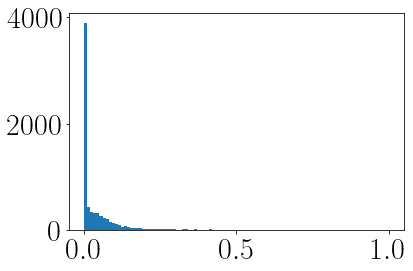

In [49]:
plt.hist(df_random.VSCATTER, 100, range=(0, 1));
print(len(df_random.VSCATTER.values[df_random.VSCATTER.values > 1.]))

# A few tests.

In [50]:
# np.array([k for k in df_random.keys()])

In [51]:
[col for col in df_random.columns if "rv" in col]

['dr2_rv_nb_transits',
 'dr2_rv_template_teff',
 'dr2_rv_template_logg',
 'dr2_rv_template_fe_h',
 'lamost_corrected_rv',
 'apogee_corrected_rv',
 'rv',
 'rv_err']

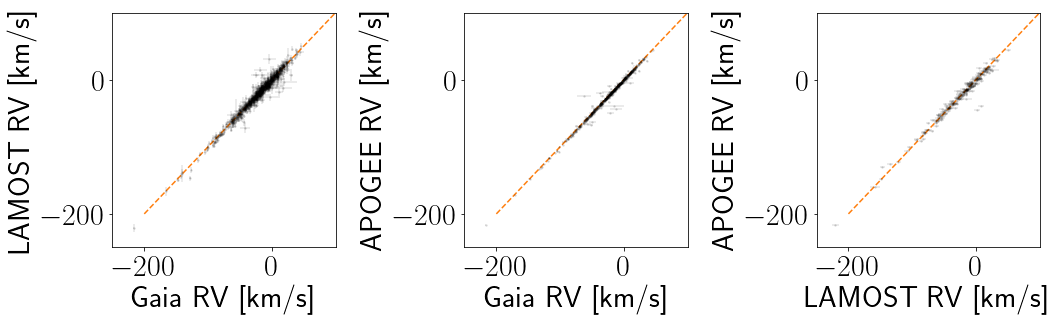

In [52]:
plt.figure(figsize=(15, 5))

thin = 10
xs = np.linspace(-200, 200, 100)

plt.subplot(1, 3, 1)
plt.errorbar(df_random.dr2_radial_velocity[::thin], df_random.lamost_corrected_rv[::thin],
             yerr=df_random.LAMOST_RV_ERR[::thin],
             xerr=df_random.dr2_radial_velocity_error[::thin],
             fmt="k.", rasterized=True, ms=3, alpha=.1)
plt.plot(xs, xs, ls="--", color="C1", zorder=0)
plt.xlim(-250, 100)
plt.ylim(-250, 100)
plt.xlabel("Gaia RV [km/s]")
plt.ylabel("LAMOST RV [km/s]")

plt.subplot(1, 3, 2)
plt.errorbar(df_random.dr2_radial_velocity[::thin], df_random.apogee_corrected_rv[::thin],
             yerr=df_random.APOGEE_RV_ERR[::thin],
             xerr=df_random.dr2_radial_velocity_error[::thin],
             fmt="k.", rasterized=True, ms=3, alpha=.1)
plt.plot(xs, xs, ls="--", color="C1", zorder=0)
plt.xlim(-250, 100)
plt.ylim(-250, 100)
plt.xlabel("Gaia RV [km/s]")
plt.ylabel("APOGEE RV [km/s]")

plt.subplot(1, 3, 3)
plt.errorbar(df_random.lamost_corrected_rv[::thin], df_random.apogee_corrected_rv[::thin],
             yerr=df_random.APOGEE_RV_ERR[::thin],
             xerr=df_random.LAMOST_RV_ERR[::thin],
             fmt="k.", rasterized=True, ms=3, alpha=.1)
plt.plot(xs, xs, ls="--", color="C1", zorder=0)
plt.xlim(-250, 100)
plt.ylim(-250, 100);
plt.xlabel("LAMOST RV [km/s]")
plt.ylabel("APOGEE RV [km/s]")

plt.tight_layout()

Uncertainty histograms.

4.960000038146973
0.0110245
1.0008625984191895


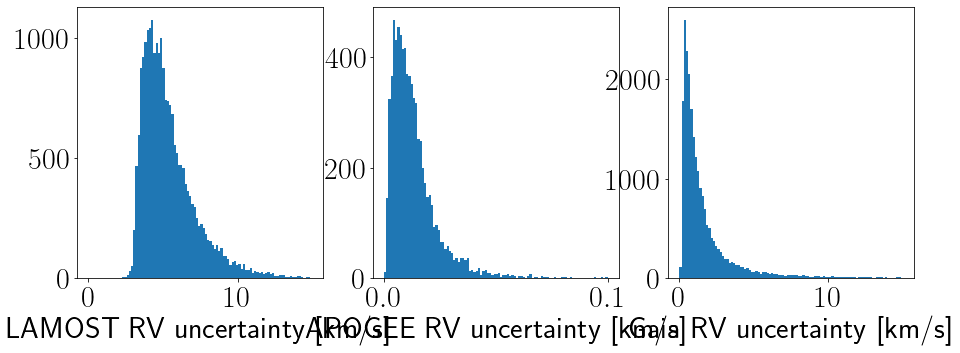

In [61]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_random.LAMOST_RV_ERR, 100, range=(0, 15));
plt.xlabel("LAMOST RV uncertainty [km/s]")
print(np.median(df_random.LAMOST_RV_ERR.values[np.isfinite(df_random.LAMOST_RV_ERR.values)]))

plt.subplot(1, 3, 2)
plt.hist(df_random.APOGEE_RV_ERR, 100, range=(0, .1));
plt.xlabel("APOGEE RV uncertainty [km/s]")
print(np.median(df_random.APOGEE_RV_ERR.values[np.isfinite(df_random.APOGEE_RV_ERR.values)]))

plt.subplot(1, 3, 3)
plt.hist(df_random.dr2_radial_velocity_error, 100, range=(0, 15));
plt.xlabel("Gaia RV uncertainty [km/s]")
print(np.median(df_random.dr2_radial_velocity_error.values[np.isfinite(df_random.dr2_radial_velocity_error.values)]))